In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from sklearn import model_selection
from sklearn import preprocessing
import seaborn as sns

Using TensorFlow backend.


In [2]:
df_Beijing = pd.read_csv('BeijingPM20100101_20151231.csv')
df_Chengdu = pd.read_csv('ChengduPM20100101_20151231.csv')
# df_Guangzhou = pd.read_csv('GuangzhouPM20100101_20151231.csv')
# df_Shanghai = pd.read_csv('ShanghaiPM20100101_20151231.csv')
# df_Shenyang = pd.read_csv('ShenyangPM20100101_20151231.csv')
df_Beijing

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,52580,2015,12,31,19,4,140.0,157.0,122.0,133.0,-8.0,68.0,1031.0,-3.0,SE,7.14,0.0,0.0
52580,52581,2015,12,31,20,4,157.0,199.0,149.0,169.0,-8.0,63.0,1030.0,-2.0,SE,8.03,0.0,0.0
52581,52582,2015,12,31,21,4,171.0,231.0,196.0,203.0,-10.0,73.0,1030.0,-6.0,NE,0.89,0.0,0.0
52582,52583,2015,12,31,22,4,204.0,242.0,221.0,212.0,-10.0,73.0,1030.0,-6.0,NE,1.78,0.0,0.0


In [3]:
# col=['year','month','day','hour','HUMI','PRES','Iws','Iprec']
# df1 = pd.DataFrame(df_Beijing,columns=col)
# df2 = pd.DataFrame(df_Chengdu,columns=col)
# df1['Date']=pd.to_datetime(df1[['year','month','day','hour']])
# df2['Date']=pd.to_datetime(df2[['year','month','day','hour']])
# df1 = df1[['Date','HUMI','PRES','Iws','Iprec']]
# df1.sort_values('Date', inplace=True)
# df2 = df2[['Date','HUMI','PRES','Iws','Iprec']]
# df2.sort_values('Date', inplace=True)

In [19]:
col=['year','month','day','hour','HUMI','PRES','Iws','Iprec','PM_US Post']
col_4feature=['HUMI','PRES','Iws','Iprec']
list_of_cmaps=['Blues','Greens','Reds','Purples']

def preprocess_data(df_data,city):
    df = pd.DataFrame(df_data,columns=col)
    
    df['Date'] = pd.to_datetime(df[['year','month','day','hour']])
    
    df = df[['Date','HUMI','PRES','Iws','Iprec','PM_US Post']]
    df.sort_values('Date', inplace=True)
    
    print(df)
#     df['City'] = city
#     df['PM2.5_level'] = 0
    
    
    df[df.columns[1:]] = df[df.columns[1:]].apply(pd.to_numeric, errors='coerce')
    df = df.fillna(df.median()) # จัดการข้อมูลหาย แทนที่ด้วย median
    df = df.drop_duplicates()
    

#     print("ysy",df.iloc[df['PM_US Post']<10,df.columns.get_loc('PM2.5_level')])
#     df.iloc[df['PM_US Post']<10,df.columns.get_loc('PM2.5_level')]=0
#     df.iloc[df['PM_US Post']>=10 and df['PM_US Post']<=25,df.columns.get_loc('PM2.5_level')]=1
#     df.iloc[df['PM_US Post']>25,df.columns.get_loc('PM2.5_level')]=2
#     print(df)
    
    
    
    df['PM_US Post'] = df['PM_US Post'].map('PM_US Post_{}'.format)
    print("Before Cleaning")
    hist = df.hist(bins=8,figsize=(5,5))
    axes = df.plot.line(x='Date', subplots=True, figsize=(8, 5))
    g = sns.PairGrid(df ,hue='PM_US Post', hue_kws={"cmap":list_of_cmaps},)
    g.map_upper(plt.scatter)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.distplot)
    
    df['timediff'] = (df['Date']-df['Date'].shift().shift()).fillna(0)
    print('median timediff : ',df['timediff'].median())
    return df

def resample(df,resample='1H'):
    df = df.set_index('Date').resample(resample).mean()
    df.interpolate(inplace=True)
    df = df.rolling(5).mean()
    
    df['City'] = df['City'].map('City'.format)
    print("After Cleaning")
    hist = df.hist(bins=8,figsize=(5,5))
    axes = df.plot.line(x='Date', subplots=True, figsize=(8, 5))
    g = sns.PairGrid(df ,hue='PM2.5_level', hue_kws={"cmap":list_of_cmaps},)
    g.map_upper(plt.scatter)
    g.map_lower(sns.kdeplot)
    g.map_diag(sns.distplot)
    
    return df

def standardized_norm(df):
    x = df.values #returns a numpy array
    standard_scaler = preprocessing.StandardScaler() #Standardized Norm
    x_standard_scaled = standard_scaler.fit_transform(x)
    df = pd.DataFrame(x_standard_scaled,columns=col_4feature)
    df.plot()
    return df

                     Date  HUMI    PRES    Iws  Iprec  PM_US Post
0     2010-01-01 00:00:00  43.0  1021.0   1.79    0.0         NaN
1     2010-01-01 01:00:00  47.0  1020.0   4.92    0.0         NaN
2     2010-01-01 02:00:00  43.0  1019.0   6.71    0.0         NaN
3     2010-01-01 03:00:00  55.0  1019.0   9.84    0.0         NaN
4     2010-01-01 04:00:00  51.0  1018.0  12.97    0.0         NaN
...                   ...   ...     ...    ...    ...         ...
52579 2015-12-31 19:00:00  68.0  1031.0   7.14    0.0       133.0
52580 2015-12-31 20:00:00  63.0  1030.0   8.03    0.0       169.0
52581 2015-12-31 21:00:00  73.0  1030.0   0.89    0.0       203.0
52582 2015-12-31 22:00:00  73.0  1030.0   1.78    0.0       212.0
52583 2015-12-31 23:00:00  79.0  1029.0   2.67    0.0       235.0

[52584 rows x 6 columns]
Before Cleaning


IndexError: list index out of range

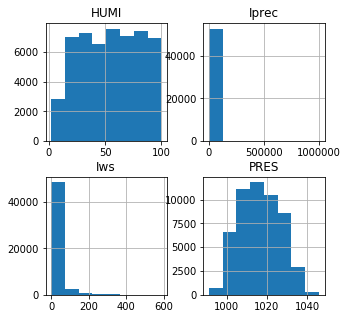

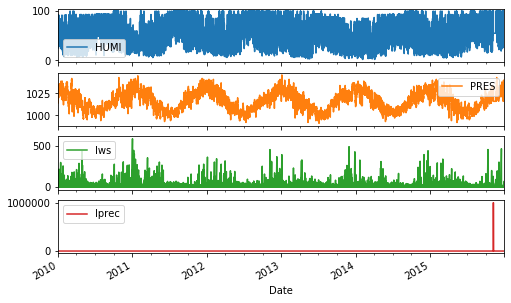

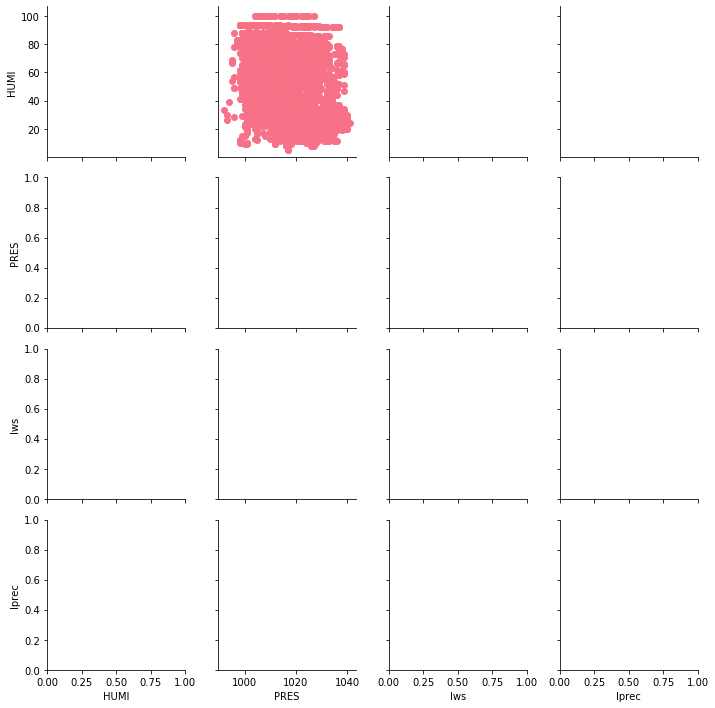

In [20]:
df1 = preprocess_data(df_data=df_Beijing,city="Beijing")
df1 = resample(df=df1,resample='2H')
df1

In [ ]:
df2 = preprocess_data(df_data=df_Chengdu)
df2 = resample(df=df2,resample='2H')
df2

In [ ]:
# df = pd.concat([df1,df2])
# df = standardized_norm(df=df)
# df

In [ ]:
g = sns.PairGrid(df2,hue='models', hue_kws={"cmap":list_of_cmaps},)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g.map_diag(sns.distplot)